In [1]:
from pathlib import Path
from collections import Counter, defaultdict
import json
from pprint import pprint
from itertools import chain, islice
import math

import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as ar
import seaborn as sns

from sklearn import metrics

import pylab as py
from tqdm.notebook import tqdm
from followthemoney import compare, compare2, model

from profiles import Profile, ProfileCollection, _describe_list, Judgement
import utils

/home/micha/work/occrp/followthemoney-predict/experiments/xref-experiments/xref_experiments/experiments/profiles/venv/lib/python3.8/site-packages/arviz/__init__.py:8: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  from matplotlib.colors import LinearSegmentedColormap
/home/micha/work/occrp/followthemoney-predict/experiments/xref-experiments/xref_experiments/experiments/profiles/profiles.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
profiles = ProfileCollection.load_dir('../../../data/profiles/')

In [3]:
profiles.describe()

Number of profiles: 4580
Mean profile size: 2.9342794759825326
STD profile size: 4.563315324584473
Median profile size: 2.0
Unique Entities: 13116
Judgement Counts: [(<Judgement.POSITIVE: 'positive'>, 9051), (<Judgement.NEGATIVE: 'negative'>, 3775), (<Judgement.UNSURE: 'unsure'>, 607), (None, 6)]
Mean entity num properties: 5.731750874321006
STD entity num properties: 3.2463865091227393
Median entity num properties: 5.0


In [4]:
user_weight = utils.create_user_weights_lookup(profiles)

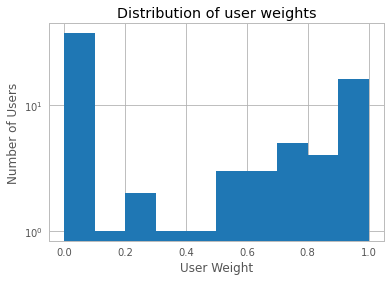

In [5]:
py.hist(user_weight.values())
py.xlabel("User Weight")
py.ylabel("Number of Users")
py.title("Distribution of user weights")
py.gca().set_yscale('log')
py.show()

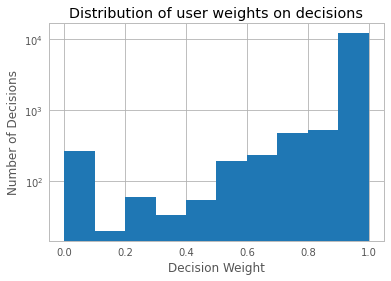

In [6]:
py.hist([user_weight[decision['added_by_id']] for decision in profiles.iter_decisions()])
py.xlabel("Decision Weight")
py.ylabel("Number of Decisions")
py.title("Distribution of user weights on decisions")
py.gca().set_yscale('log')
py.show()

In [7]:
pairs_weighted_sum = Counter()
pairs_count = Counter()
for profile in tqdm(profiles.values()):
    for (e1, e2), judgement in profile.iter_pairs(judgements={Judgement.POSITIVE, Judgement.NEGATIVE}):
        weights = utils.calculate_pair_weights(e1, e2, profile, user_weight)
        pairs_weighted_sum[judgement] += weights.user_weight * weights.pair_weight
        pairs_count[judgement] += 1
pairs_avg = Counter({j: pairs_weighted_sum[j] / pairs_count[j] for j in pairs_count.keys()})

  0%|          | 0/4580 [00:00<?, ?it/s]

In [8]:
print("Pairs Weighted Sum:")
print("Total number of pairs:", sum(pairs_weighted_sum.values()))
print("Pair judgements:")
pprint(pairs_weighted_sum.most_common())

print()

print("Pairs Weighted Average:")
print("Total number of pairs:", sum(pairs_avg.values()))
print("Pair judgements:")
pprint(pairs_avg.most_common())

Pairs Weighted Sum:
Total number of pairs: 15219.382522225744
Pair judgements:
[(<Judgement.POSITIVE: 'positive'>, 8043.651372637528),
 (<Judgement.NEGATIVE: 'negative'>, 7175.731149588216)]

Pairs Weighted Average:
Total number of pairs: 1.2391874651983628
Pair judgements:
[(<Judgement.NEGATIVE: 'negative'>, 0.9012473184612178),
 (<Judgement.POSITIVE: 'positive'>, 0.3379401467371451)]


In [9]:
pairs_weights = defaultdict(list)
pairs_compare_score = defaultdict(list)
pairs_compare2_score = defaultdict(list)
for profile in tqdm(profiles.values()):
    pairs = profile.iter_pairs(judgements={Judgement.POSITIVE, Judgement.NEGATIVE})
    for (e1, e2), judgement in pairs:
        pairs_compare_score[judgement].append(compare.compare(model, e1, e2))
        pairs_compare2_score[judgement].append(compare2.compare(model, e1, e2))

  0%|          | 0/4580 [00:00<?, ?it/s]

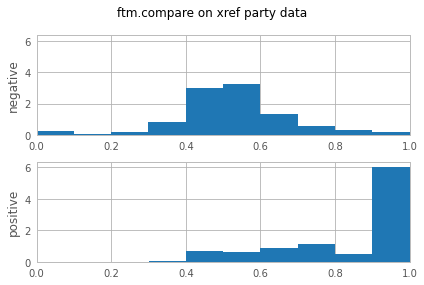

In [10]:
fig, axs = py.subplots(nrows=len(pairs_compare_score), sharey=True)
for ax, (key, values) in zip(axs, pairs_compare_score.items()):
    ax.hist(values, label=key, bins=10, density=True)
    ax.set_ylabel(key.value)
    ax.set_xlim(0, 1)
py.suptitle('ftm.compare on xref party data')
py.tight_layout()
py.show()

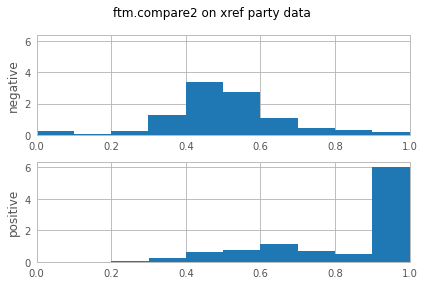

In [11]:
fig, axs = py.subplots(nrows=len(pairs_compare2_score), sharey=True)
for ax, (key, values) in zip(axs, pairs_compare2_score.items()):
    ax.hist(values, label=key, bins=10, density=True)
    ax.set_ylabel(key.value)
    ax.set_xlim(0, 1)
py.suptitle('ftm.compare2 on xref party data')
py.tight_layout()
py.show()

In [12]:
for judgement, data in pairs_compare_score.items():
    print(judgement.name)
    for threshold in (0.5, 0.7, 0.95):
        N = sum(0.2 < s < threshold for s in data)
        pct = N / len(data) * 100
        print(f'\t{judgement.name} pairs with 0.2 < compare < {threshold}: {N}: {pct:0.2f}%')
    N = sum(s < 0.5 for s in data)
    pct = N / len(data) * 100
    print(f'\t{judgement.name} pairs with 0.0 < compare < 0.5: {N}: {pct:0.2f}%')

NEGATIVE
	NEGATIVE pairs with 0.2 < compare < 0.5: 3211: 40.33%
	NEGATIVE pairs with 0.2 < compare < 0.7: 6861: 86.17%
	NEGATIVE pairs with 0.2 < compare < 0.95: 7623: 95.74%
	NEGATIVE pairs with 0.0 < compare < 0.5: 3460: 43.46%
POSITIVE
	POSITIVE pairs with 0.2 < compare < 0.5: 1852: 7.78%
	POSITIVE pairs with 0.2 < compare < 0.7: 5540: 23.28%
	POSITIVE pairs with 0.2 < compare < 0.95: 9820: 41.26%
	POSITIVE pairs with 0.0 < compare < 0.5: 1900: 7.98%


In [13]:
for judgement, data in pairs_compare2_score.items():
    print(judgement.name)
    for threshold in (0.5, 0.7, 0.95):
        N = sum(0.2 < s < threshold for s in data)
        pct = N / len(data) * 100
        print(f'\t{judgement.name} pairs with 0.2 < compare2 < {threshold}: {N}: {pct:0.2f}%')
    N = sum(s < 0.5 for s in data)
    pct = N / len(data) * 100
    print(f'\t{judgement.name} pairs with 0.0 < compare2 < 0.5: {N}: {pct:0.2f}%')

NEGATIVE
	NEGATIVE pairs with 0.2 < compare2 < 0.5: 3877: 48.69%
	NEGATIVE pairs with 0.2 < compare2 < 0.7: 6936: 87.11%
	NEGATIVE pairs with 0.2 < compare2 < 0.95: 7617: 95.67%
	NEGATIVE pairs with 0.0 < compare2 < 0.5: 4132: 51.90%
POSITIVE
	POSITIVE pairs with 0.2 < compare2 < 0.5: 2142: 9.00%
	POSITIVE pairs with 0.2 < compare2 < 0.7: 6572: 27.61%
	POSITIVE pairs with 0.2 < compare2 < 0.95: 9820: 41.26%
	POSITIVE pairs with 0.0 < compare2 < 0.5: 2190: 9.20%


In [14]:
pairs_compare2_score

defaultdict(list,
            {<Judgement.NEGATIVE: 'negative'>: [0.49119888604245066,
              0.5371335492470793,
              0.5371335492470793,
              0.5371335492470793,
              0.5371335492470793,
              0.5371335492470793,
              0.554276109329433,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5173243687074708,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5173243687074708,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5013246459639408,
              0.5173243687074708,
              0.0,
              0.0,
              0.5825915179544982,
              0.9571146366